In [1]:
import numpy as np
import pandas as pd
from torch.nn import Module
# from PIL import Image
import torch
import torch.nn.functional as func
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

class Net(Module):

    def __init__(self, shape):
        # possible shapes include:
        #   4912 x 7360 x 3
        #   4016 x 6016 x 3
        #   2008 x 3008 x 3

        super(Net, self).__init__()
        self.first_conv = torch.nn.Conv2d(shape[2], 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.reduction1 = torch.nn.Linear(18 * (shape[0]/2) * (shape[1]/2), 64)
        self.reduction2 = torch.nn.Linear(64, 10) #10 is the number of possible solutions

    def forward(self, data):
        #convert to a x y x 18
        data = func.relu(self.first_conv(data))
        #convert to (a/2) x (y/2) x 18
        data = self.pool(data)
        sh = data.shape
        #convert shape to (-1, ((a/2) x (y/2) x 18))
        data = data.view(-1, (sh[0] * sh[1] * sh[2]))
        data = func.relu(self.reduction1(data))
        data = self.reduction2(data)
        return data

    def error(self):
        return torch.nn.CrossEntropyLoss()

training_data = []
weights = []

def load_data(filename):
    f = open(filename, "r")
    for line in f:
        im = Image.open(line)
        matrix = np.array(im)
        matrix = ((matrix[0] * matrix[1]), matrix[2])
        training_data.append(matrix)
    f.close()

def train_cnn():
    training_data

def initialize_weights():
    n = Net(training_data[0].shape)
    for x in training_data:
        n.forward(x)
        

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [2]:
import os
def rename(path):
    """Rename pictures with extension of '.JPG' to '.jpg', use only if necessary with the module being used"""
    files = os.listdir(path)
    for index, file in enumerate(files):
        name = file[:-4]
        extension = file[-4:]
        if extension == ".JPG":
            os.rename(os.path.join(path, file), os.path.join(path, ''.join([name, '.jpg'])))

In [ ]:
pics = {}
np_pics = []
def add_to_list_file(line, matrix):
    pics[f] = im
    print(im.shape)
    np_pics.append(im.flatten())

def run_kmeans_file(matrix, clusters):
    f = open('groupings.txt', 'a')
    km = KMeans(n_clusters=clusters)
    km.fit(matrix)
    index_set = {i: np.where(km.labels_ == i)[0] for i in range(km.n_clusters)} #index of pictures in data
    files = list(pics)
    for i in range(len(index_set)):
        c = index_set[i]
        for v in c:
            f.write(files[v] + "\n")
            print(files[v])
        f.write('-----------')
        print('------------')
    f.close()

def pca_file(n):
    all_samples = np.vstack(np_pics)
    print(all_samples.shape)
    pca = PCA(n_components=n)
    return pca.fit_transform(all_samples)

def run_files():
    count = 0
    for inputs, labels in trainloader:
        count = count + 1
        line = "../../../../.." + line.rstrip()
        mat3d = np.array(Image.open(line))
        mat3d = mat3d[0::2,0::2,:]
        mat2d = mat3d.reshape((mat3d.shape[0] * mat3d.shape[1]), mat3d.shape[2])
        add_to_list_file(line, mat2d)
        if(count >= 250):
            break
    matrix = pca_file(int(input("How many components would you like to compress: ")))
    run_kmeans_file(matrix, int(input("How many clusters would you like to group: ")))

In [3]:
"""define the train / validation dataset loader, using the SubsetRandomSampler for the split"""

data_dir = "../../../../../mnt/md0/mysql-dump-economists/Archives"#/Fall"#/Dump"

def load_split_train_test(datadir, valid_size = .2):
    
    # Helper/controller params for checking size
    find_size_bounds = False #set to true if you are looking for min/max dims in the current set, false if you want them to be resized
    limit_num_pictures = 1000 #set to null if you want no limit
    
    # define transforms to resize (look into 'Rescale'??) images to desired size and transform them into tensors
    """ more on other transforms (RandomHorizontalFlip ("double" dataset") and RandomResizedCrop (increase 
        robustness and also artificially "increases" our dataset) from a SO post: 
        https://stackoverflow.com/questions/50963295/pytorch-purpose-of-images-preprocessing-in-the-transfer-learning-tutorial
    """
    train_transforms = transforms.Compose([transforms.Resize((425,242)),transforms.ToTensor(),]) if not find_size_bounds else transforms.Compose([transforms.ToTensor(),])
    test_transforms = transforms.Compose([transforms.Resize((425,242)),transforms.ToTensor(),]) if not find_size_bounds else transforms.Compose([transforms.ToTensor(),])
    
    # load data and apply the transforms on contained pictures
    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)   
    
    maxh = 0
    minh = 10000
    maxw = 0
    minw = 10000
    if find_size_bounds:
        try:
            for (i, pic) in enumerate(train_data):
                #if we are limiting pics
                if limit_num_pictures:
                    if i > limit_num_pictures:
                        break
                print(pic[0].size())
                if pic[0].size()[1] > maxw:
                    maxw = pic[0].size()[1]
                elif pic[0].size()[1] < minw:
                    minw = pic[0].size()[1]

                if pic[0].size()[2] > maxh:
                    maxh = pic[0].size()[2]
                elif pic[0].size()[2] < minh:
                    minh = pic[0].size()[2]
        except Exception as e:
            print(e)
            print("error occurred on pic {} number {}".format(pic, i))
    
        print("Max/min width: {} {}".format(maxw, minw))
        print("Max/min height: {} {}".format(maxh, minh))
    
    num_pictures = len(train_data)
    print("Number of pictures in subdirectories: {}".format(num_pictures))
    
    # Shuffle pictures and split training set
    indices = list(range(num_pictures))
    print("Head of indices: {}".format(indices[:10]))
    
    split = int(np.floor(valid_size * num_pictures))
    print("Split index: {}".format(split))
    
    # may be unnecessary with the choice of sampler below
#     np.random.shuffle(indices)
#     print("Head of shuffled indices: {}".format(indices[:10]))
    
    train_idx, test_idx = indices[split:], indices[:split]
    print("Size of training set: {}, size of test set: {}".format(len(train_idx), len(test_idx)))
    
    # Define samplers that sample elements randomly without replacement
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    # Define data loaders, which allow batching the data, shuffling the data, and 
    #     loading the data in parallel using multiprocessing workers
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=1, num_workers=4)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=1, num_workers=4)
    return trainloader, testloader
# rename("/mnt/md0/mysql-dump-economists/Archives/1999/Fall/Dump/Beard, Rebecca")
trainloader, testloader = load_split_train_test(data_dir, .2)
print("trainloader: {}".format(trainloader))
print("Classes: {}".format(trainloader.dataset.classes))
run_files()

Number of pictures in subdirectories: 106388
Head of indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Split index: 21277
Size of training set: 85111, size of test set: 21277
trainloader: <torch.utils.data.dataloader.DataLoader object at 0x7f3e51ed5c90>
Classes: ['1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', 'Archive Scans', 'Fall', 'Spring', 'Summer', 'zLibrary Scans', 'zzVolunteer']


In [4]:
"""Not necessary to run, just curious. Loads a pretrained model, printing the model just to see 
    the layer architecture of the ResNet model.
    List of other models: https://pytorch.org/docs/stable/torchvision/models.html"""
# enable CUDA tensor types, that implement the same function as CPU tensors, but they 
#     utilize GPUs for computation (if the device we are on has GPUs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
print(model)

"""
First, we have to freeze the pre-trained layers, so we don’t backprop through them during training. 
Then, we re-define the final fully-connected the layer, the one that we’ll train with our images. 
We also create the criterion (the loss function) and pick an optimizer (Adam in this case) and learning rate.
"""

for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
"""
You load the batches of images and do the feed forward loop. 
Then calculate the loss function, and use the optimizer to apply gradient descent in back-propagation.
Most of the code below deals with displaying the losses and calculate accuracy every 10 batches, 
    so you get an update while training is running. 
During validation, don’t forget to set the model to eval() mode, and then back to train() once you’re finished.
"""
epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        
        if steps > 10:
            break
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape) 
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'cnn_classifier_model.pth')

RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /pytorch/aten/src/THNN/generic/ClassNLLCriterion.c:97

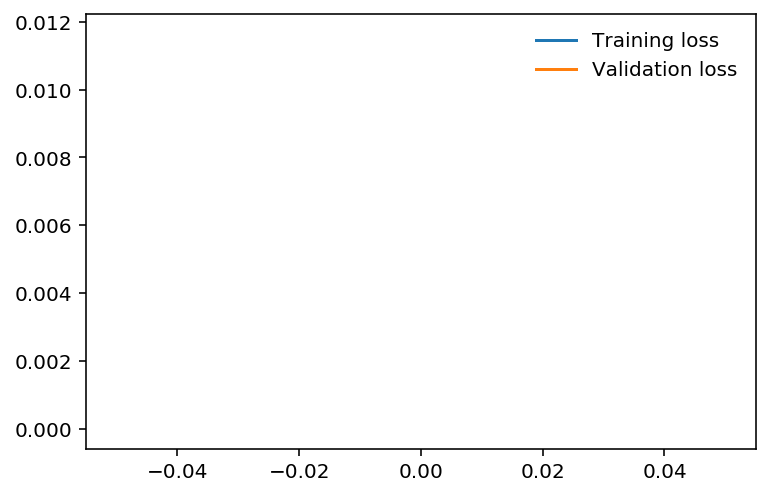

In [19]:
"""plot the training and validation losses"""
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [22]:
""" again we check for GPU availability, load the model and put it into evaluation mode 
    (so parameters are not altered)"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('cnn_classifier_model.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
"""function that predicts the class of a specific image"""
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [24]:
"""function that will pick a number of random images from the dataset folders"""
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [27]:
"""demo the prediction function, I get the random image sample, predict them and display the results"""
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

NameError: name 'test_transforms' is not defined